# History Matching for L96
Author : Redaoune Lguensat, Homer Durand

Date : 26-07-21

### Loading libs

In [1]:
PATH = '/home/homer/anaconda3/envs/HM/bin/python'
Sys.setenv(RETICULATE_PYTHON = PATH)

current_dir <- getwd()
mogp_dir <- current_dir #mogp_emulator lib : https://github.com/alan-turing-institute/mogp-emulator

setwd(paste0(current_dir, '/dev_ExeterUQ_MOGP/')) #devel version og ExeterUQ_MOGP : https://github.com/BayesExeter/ExeterUQ_MOGP/tree/devel

source("BuildEmulator/BuildEmulator.R")
source("HistoryMatching/HistoryMatching.R")
source("HistoryMatching/impLayoutplot.R")

setwd(current_dir)

r_packages <- c("future.apply", 'tgp', 'ANN2', 'MLmetrics', 'keras')
invisible(lapply(r_packages, library, character.only = TRUE))

python_pkg <- c("L96_amip", "numpy", "sklearn", "skopt.sampler", "skopt.space")
python_pkg_names <- c("L96_amip", "np", "sklearn", "sampler", "skSpace")
for(i in seq(length(python_pkg))){assign(python_pkg_names[i], import(python_pkg[i]))}

far library : Modelization for Functional AutoRegressive processes


version 0.6-4 (2014-12-07)


Spam version 2.6-0 (2020-12-14) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 

This is loo version 2.4.1

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

Loading required package: future


Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall



Attaching package: ‘keras’


The following

# History Matching

1. Space filling design of parameters space
2. Data simulation
3. Training of statistical emulator
4. Computation of implausibility
5. Refocussing
    * If stoping criterion is reached stop HM
    * Else, redefining parameters space and go to 1.

## Observations generation

As our model is a toy model we need to generate *observations* based on the ground truth parameters in order to use them to tune our model. In a realistic model (e.g. an ocean model), observations are metrics based on real observations of the state of the ocean threw time.

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} \underbrace{-h c \bar{Y}_{k}}_{\text {Coupling}}$

$\frac{1}{c} \frac{d Y_{j, k}}{d t}=\underbrace{-b Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{-Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h}{J} X_{k}}_{\text {Coupling }}$

We consider the correct parameters to be h=1, F=10, c=10, b=10 and we will first generate our metrics based on those inputs using the 65 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}_k(Y)=\left(\begin{array}{c}
Y_{j,k} \\
Y_{j,k}Y_{j',k}
\end{array}\right), \forall j, j' \in J \text{ and } k \in K
$$

In [2]:
np$random$seed(as.integer(42))

X_init = 10*np$ones(as.integer(36))
X_init[19]=1.0001 #ATtention X_init[19] !!!

l96_two = L96_amip$L96TwoLevel(save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

We first iterate 10 iterations in order to access to the steady state of the L96 model

In [3]:
l96_two$iterate(10)

In [4]:
Newinit = l96_two$X
Newinit

[1]  4.42757870 -1.95495041  4.02579735  7.58204632  1.62852532  0.39357305
 [7] -0.27120997  0.50364081  1.39288414  7.19375682  4.24944906  4.31670564
[13] 10.65758988  3.57441467  0.28612741  1.59561931  5.81580349 -0.01928225
[19]  9.29077971  2.98459204  0.23466043 -1.10569887  5.99612019  5.39444981
[25]  1.73690034  0.13736713  1.49172092 -1.82474446 -0.34535066 10.71303763
[31]  1.52854734 -1.29510637  0.11986749  2.52317066  4.46499941 10.24747885

We can use *Newinit* to be sure to start from the attractor of the L96.

In [5]:
np$random$seed(as.integer(42))
n_iter <- 20
dt <- 0.001
l96_two = L96_amip$L96TwoLevel(save_dt=dt, X_init=Newinit, integration_type='coupled') 

In [6]:
l96_two$iterate(n_iter)

We save the history of X in order to reinject it during the Y integration.

In [7]:
X_hist <- l96_two$history$X$values

We save the metrics generate with the ground truth parameters (observations).

In [8]:
system.time(observations <- l96_two$mean_stats(ax=as.integer(0)))

   user  system elapsed 
  3.776   0.020   3.800 

We now have our ground truth metrics and history of X wo we can tune our model.

### Generation of metrics for the first wave

We first sample the parameters space (input space) using a space filling design (latin hypercube sampling with maximin criterion) and then will generate our metrics for each of those points of the parameter space.

In [9]:
sampler <- import('skopt.sampler')
skSpace <- import('skopt.space')

In [10]:
n_samples <- 30

Attention Hammersly Sampling ici !!!

In [11]:
space <- skSpace$Space(list(c(-2, 2), c(0, 20), c(-20, 20))) ##only h,c,b
lhs <- sampler$Sobol()  #Attention Hammersly Sampling
inputs_wave1 <- np$array(lhs$generate(space$dimensions, as.integer(n_samples), random_state=as.integer(42)))

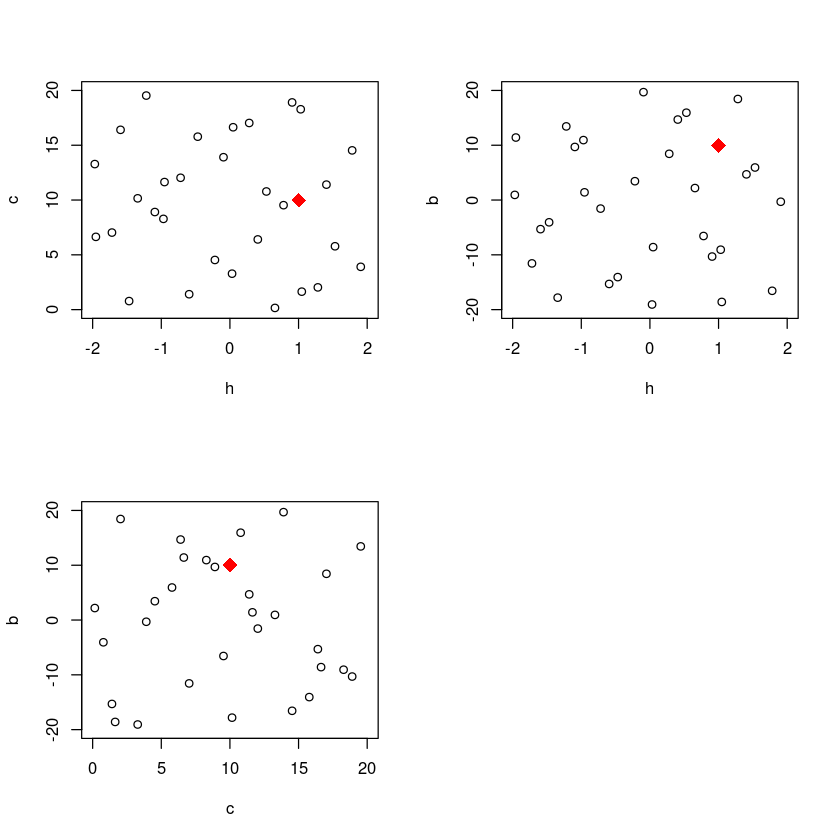

In [12]:
par(mfrow=c(2,2))
plot(inputs_wave1[,1], inputs_wave1[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,1], inputs_wave1[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(inputs_wave1[,2], inputs_wave1[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

As a rule of thumb, we use 10 samples by paramaters. Here we have 3 parameters to tune (h, c, b), so we use 30 samples.

In [13]:
extract_metrics_AMIP <- function(p, n_iter, dt, X_hist) {
    initX <- as.matrix(X_hist[1,])
    l96_mip = L96_amip$L96TwoLevel(X_init=initX, save_dt=dt, dt=dt, noYhist=FALSE, h=p[[1]], F=10, c=p[[2]], b=p[[3]])
    l96_mip$iterate_AMIP(X_hist, n_iter)
    return(l96_mip$mean_stats(ax=as.integer(0)))
}

In [14]:
plan(multicore)
metrics_wave1 = future_sapply(1:nrow(inputs_wave1), function(r) extract_metrics_AMIP(inputs_wave1[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix
We create a data frame with correct format to train an emulator as it is describe in https://bayesexeter.github.io/ExeterUQ_MOGP/Testing_ExeterUQ_mogp.html

We select 65 metrics for a given k (here $k=0$) in order to fit the emulators in a reasonable amount of time. Here we select the metrics 

$$
\boldsymbol{f}_0(Y)=\left(\begin{array}{c}
Y_{j,0} \\
Y_{j,0}Y_{j',0}
\end{array}\right), \forall j, j' \in J
$$

#### Scaling and Unscaling functions

In [15]:
rangeScale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (range[2] - range[1])*(df[,i] - min)/(max - min) + range[1]
    }
    return(df)
}
                                        
rangeUnscale <- function(df, scaler, range = c(-1, 1)){
    for (i in 1:ncol(df)){
        min <- scaler[[i]][1]
        max <- scaler[[i]][2]
        df[,i] = (max - min)*(df[,i] - range[1])/(range[2] - range[1]) + min
    }
    return(df)
}

In [16]:
k <- 0 # Select k in K for tunning 
metrics_index_k <- (k*65+1):((k+1)*65)

In [17]:
# Arrange inputs (parameters) 
inputs_wave1 <- data.frame(inputs_wave1)
my_bounds <- data.frame(list(c(-2, 2), c(0, 20), c(-20, 20)))
inputs_wave1 <- rangeScale(inputs_wave1, my_bounds, range = c(-1, 1))
names(inputs_wave1) <- c('h', 'c', 'b')


metrics_k_wave1 <- data.frame(t(metrics_wave1)[, metrics_index_k])
N = nrow(inputs_wave1) 
noise <- rnorm(N, 0, 0)
tData <- data.frame(cbind(inputs_wave1, noise, metrics_k_wave1))
names(tData)[names(tData) == "noise"] <- "Noise"
         
head(tData)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.328125,-0.984375,0.109375,0,0.118484758,0.11555613,0.115088762,0.11503599,0.115178868,0.11515524,⋯,0.0141920085,0.0142222743,0.014626060,0.0143195838,0.014252619,0.0146576225,0.014350428,0.0150970266,0.0147796795,0.014470008
2,-0.671875,0.015625,-0.890625,0,-0.066678394,-0.07936401,-0.089824404,-0.07523717,-0.084169441,-0.10220934,⋯,0.0648140953,0.0166329201,0.008191256,0.0156816413,0.074029575,0.0184943941,0.002098744,0.0967070892,0.0230490110,0.077765279
3,-0.546875,-0.109375,0.484375,0,0.001990445,-0.09224118,0.002165304,-0.06585666,0.052131441,-0.09581137,⋯,0.0321937318,-0.0030655675,0.014744773,-0.0032817246,0.044839838,-0.0000297872,0.026801288,0.0331836646,-0.0054455410,0.055826340
4,0.453125,0.890625,-0.515625,0,-0.015613651,0.11559553,-0.055578254,0.09508821,-0.065505231,0.10130728,⋯,0.0140571123,-0.0041967574,0.006491376,-0.0065370861,0.042499538,0.0004406626,0.022370645,0.0182742860,-0.0066464490,0.036224866
5,0.953125,-0.609375,-0.015625,0,0.510255901,0.46692169,0.476430028,0.47537145,0.471124589,0.47680591,⋯,0.4188845463,0.4338995395,0.377000928,0.4248968191,0.450210204,0.3898845427,0.441613508,0.3436080355,0.3882843222,0.456045243
6,-0.046875,0.390625,0.984375,0,-0.008068515,-0.02528188,-0.003227505,-0.02239116,-0.003031498,-0.02323721,⋯,0.0004181744,0.0004162375,0.000343111,0.0002281911,0.001479524,0.0003561716,0.001395420,0.0003353052,0.0002128817,0.001598221


### Training emulator

In [18]:
cands <- names(tData)[1:3]
em_wave1 <- BuildNewEmulators(tData, HowManyEmulators = ncol(metrics_k_wave1), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.0430805274880342 using h"
[1] "Max reduction is 0.005306477263872 using c"
[1] "Max reduction is 0.00298660905785852 using h"
[1] "Max reduction is 0.00636446923922965 using Three Way Interactions with h"
[1] "Max reduction is 0.000917584122330284 using h"
[1] "Max reduction is 0.00611025151100035 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ h + I(h^2) + I(h^3) + I(h^4) + c + I(c * h) + 
    I(h * c * h), data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.108254 -0.050512  0.007353  0.051711  0.106499 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)   0.007205   0.025924   0.278   0.7837  
h             0.074431   0.057382   1.297   0.2080  
I(h^2)       -0.250460   0.157478  -1.590   0.1260  
I(h^3)        0.161440   0.088772   1.819   0.0826 .
I(h^4)        0.380730   0.171545   2.219   0.0371 *
c             0.033243   0.035733   0.930   0.3623  
I(c * h)     -0.108233 

We can use Leave One Out to verify if our GPs fit our metrics correctly.

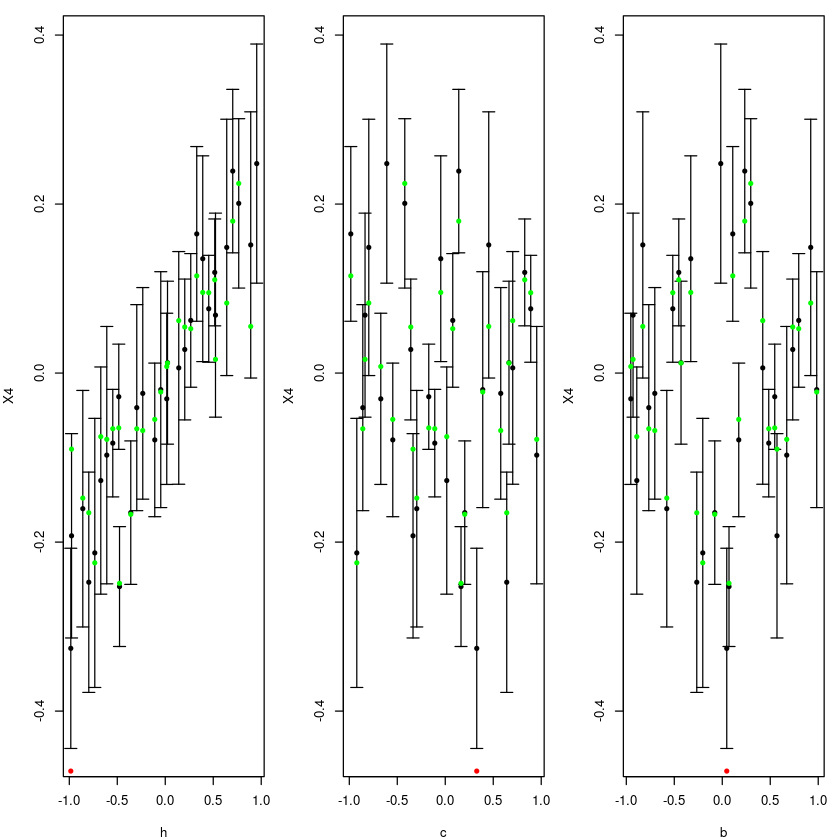

In [19]:
tLOOs <- LOO.plot(Emulators = em_wave1, which.emulator = 4, ParamNames = cands)

### Compute implausibility

We will compute implausibility as it is described in *Williamson & al. (2017)*.

$$
I_i(x_0) = \frac{|z_i - \mathbf{E}[f_i(x_0)]|}{|Var[z_i - \mathbf{E}[f_i(x_0)]]|} \\
I(x_0) = max_i(I_i(x_0))
$$

We consider that $Var[z_i - \mathbf{E}[f_i(x_0)]] = Var[e] +
Var[g] + Var[f(x_0)]$  like it is describe in *Williamson & al. (2017)*. 

With $Var[e]$ the observational
error variance, $Var[g]$ the model discrepancy variance
and $Var[f(x)]$ the variance of the emulator.

In [20]:
tDisc <- rep(0, ncol(metrics_k_wave1)) # model discrepancy variance Var[g] 
tObsErr <- rep(0, ncol(metrics_k_wave1)) # observational error variance Var[e]
tObs <-  as.vector(observations[metrics_index_k]) # Observations

We generate a large sampling of the parameter space (that we have scaled) and will compute implausibility for each point of this parameters space.

In [21]:
sample_size <- 100000
nparam <- length(names(em_wave1$fitting.elements$Design))
Xp <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp) <- names(em_wave1$fitting.elements$Design)
system.time(Timps <- ImplausibilityMOGP(NewData=Xp, Emulator=em_wave1, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 77.445  26.222  16.697 

In [22]:
VarNames <- names(Xp)
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off
param.def = data.frame(h=c(1),c=c(10),b=c(10)) #the default parameters of the model (on [-1,1])
param.defaults.norm = rangeScale(param.def, my_bounds, range(-1,1))
print(param.defaults.norm)

    h c   b
1 0.5 0 0.5


In [23]:
NROY1 <- which(rowSums(Timps <= cutoff) >= em_wave1$mogp$n_emulators -valmax)
scoreNROY1 <- length(NROY1)/dim(Xp)[1]
scoreNROY1

[1] 0.22594

The first wave of tuning allowed us to reject approximately 70% of the parameters space.

### Layout of NROY space

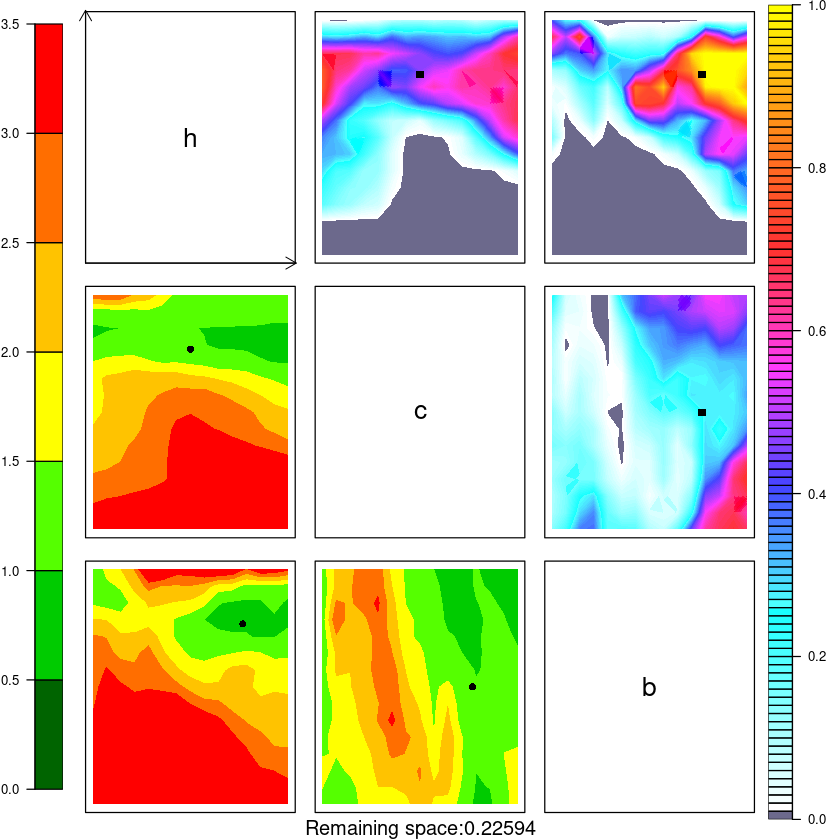

In [24]:
ImpData_wave1 = cbind(Xp, Timps)
ImpListM1 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave1, nEms=em_wave1$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM1,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY1,sep=""), side=1)

## Second Wave

We will generate a large number of samples in the entire parameters space in order to obtain *n_samples* samples in the NROY space created with the emulator *em_wave1*.

In [25]:
n <- ceiling(n_samples*1.3/scoreNROY1)

In [26]:
space <- skSpace$Space(list(c(-1, 1), c(-1, 1), c(-1, 1))) ## we use a scaled space
inputs_wave2_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

We find the points of NewData wich fall in the NROY space of each emulator in *emulators*.

In [27]:
parameters_space <- function(emulators, NewData, n_samples=n_samples){
    NROY_em <- 1:nrow(NewData)
    for (em in emulators){
        imp_em <- ImplausibilityMOGP(NewData=NewData, Emulator=em, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr)
        NROY_temp <- which(rowSums(imp_em <= cutoff) >= em$mogp$n_emulators - valmax)
        NROY_em <- intersect(NROY_em, NROY_temp)
    }
    return(sample(NROY_em, n_samples))
}

In [28]:
emulators <- list(em_wave1)
NROY_temp_wave2 <- parameters_space(emulators, inputs_wave2_scaled_temp, 30)

We now have our new inputs for wave 2.

We need to unscale those inputs for metrics simulations.

In [29]:
input_wave2_scaled <- inputs_wave2_scaled_temp[sample(NROY_temp_wave2, n_samples),]
input_wave2 <- rangeUnscale(input_wave2_scaled, my_bounds, range = c(-1, 1))

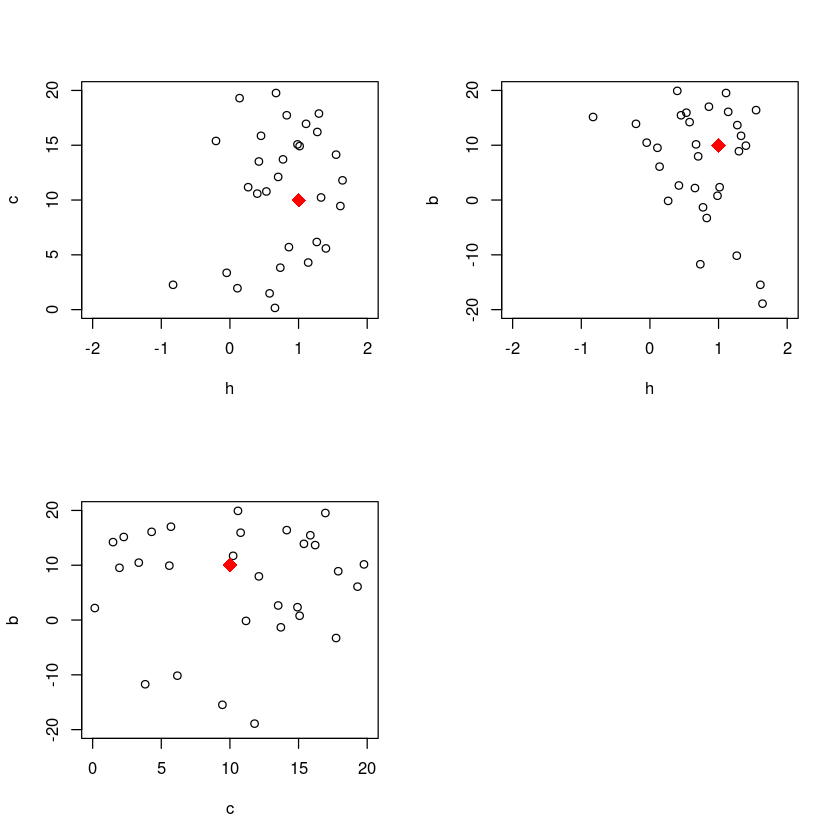

In [30]:
par(mfrow=c(2,2))
plot(input_wave2[,1], input_wave2[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave2[,1], input_wave2[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave2[,2], input_wave2[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [31]:
metrics_wave2 = future_sapply(1:nrow(input_wave2), function(r) extract_metrics_AMIP(input_wave2[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [32]:
input_wave2_scaled <- data.frame(input_wave2_scaled)
names(input_wave2_scaled) <- c('h', 'c', 'b')


metrics_k_wave2 <- data.frame(t(metrics_wave2)[, metrics_index_k])
N = nrow(metrics_k_wave2) 
noise <- rnorm(N, 0, 0)
tData_wave2 <- data.frame(cbind(input_wave2_scaled, noise, metrics_k_wave2))
names(tData_wave2)[names(tData_wave2) == "noise"] <- "Noise"
         
head(tData_wave2)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.1015625,0.53906250,0.6953125,0,-0.002553857,-0.04707723,0.005020686,-0.03753951,0.006876346,-0.04276488,⋯,0.001282492,0.0007442659,0.0009640157,-2.571102e-05,0.004855827,0.0004757848,0.004276919,0.001196413,-0.000259848,0.005125668
2,0.1992188,0.05859375,0.9960938,0,0.043908348,0.04499382,0.040196440,0.05312644,0.042040215,0.04035814,⋯,0.011432841,0.0059256959,0.0023621931,5.467495e-03,0.011755672,0.0046601233,0.002692668,0.010560746,0.005083452,0.012592713
3,0.5078125,0.49218750,0.1171875,0,0.200047587,0.22230417,0.225640448,0.22552246,0.221340064,0.21740980,⋯,0.163253101,0.1326632912,0.1256468885,1.575161e-01,0.139306099,0.1215184402,0.129803630,0.144772591,0.145742887,0.206322932
4,0.7734375,0.41406250,0.8203125,0,0.058201308,0.09067985,0.082030573,0.09738361,0.077743349,0.10132413,⋯,0.087660825,0.0220846363,0.0036724182,2.090699e-02,0.083644272,0.0202233292,-0.001318445,0.099042560,0.022086759,0.093328047
5,0.6367188,0.62109375,0.6835938,0,0.069900606,0.08250062,0.106012315,0.09049613,0.099917086,0.09262928,⋯,0.075942698,0.0191629445,0.0076871649,2.010748e-02,0.071756377,0.0218430611,0.001624837,0.087272198,0.025370418,0.072093221
6,0.2656250,0.07812500,0.7968750,0,0.053969259,0.04736846,0.065696537,0.05249063,0.061457993,0.05597123,⋯,0.018059808,0.0081850774,0.0036669988,6.181953e-03,0.020395579,0.0085699729,0.002546209,0.020806773,0.008572119,0.019875343


### Training emulator

In [33]:
em_wave2 <- BuildNewEmulators(tData_wave2, HowManyEmulators = ncol(metrics_wave2), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 0.00308091956367881 using h"
[1] "Max reduction is 0.00249471768522995 using h"
[1] "Max reduction is 0.00223687932842397 using h"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ h + I(h^2) + I(h^3), data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.087985 -0.019387 -0.001332  0.018072  0.101704 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.01181    0.02063   0.572  0.57204   
h            0.21505    0.06273   3.428  0.00203 **
I(h^2)       0.14272    0.18596   0.767  0.44973   
I(h^3)      -0.45415    0.24382  -1.863  0.07385 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05001 on 26 degrees of freedom
Multiple R-squared:  0.3294,	Adjusted R-squared:  0.252 
F-statistic: 4.256 on 3 and 26 DF,  p-value: 0.01424

[1] "Max reduction is 0.0139456199347751 using h"
[1] "Max reduction is 0.00951750501738124 using b"
[1] "Max reduction 

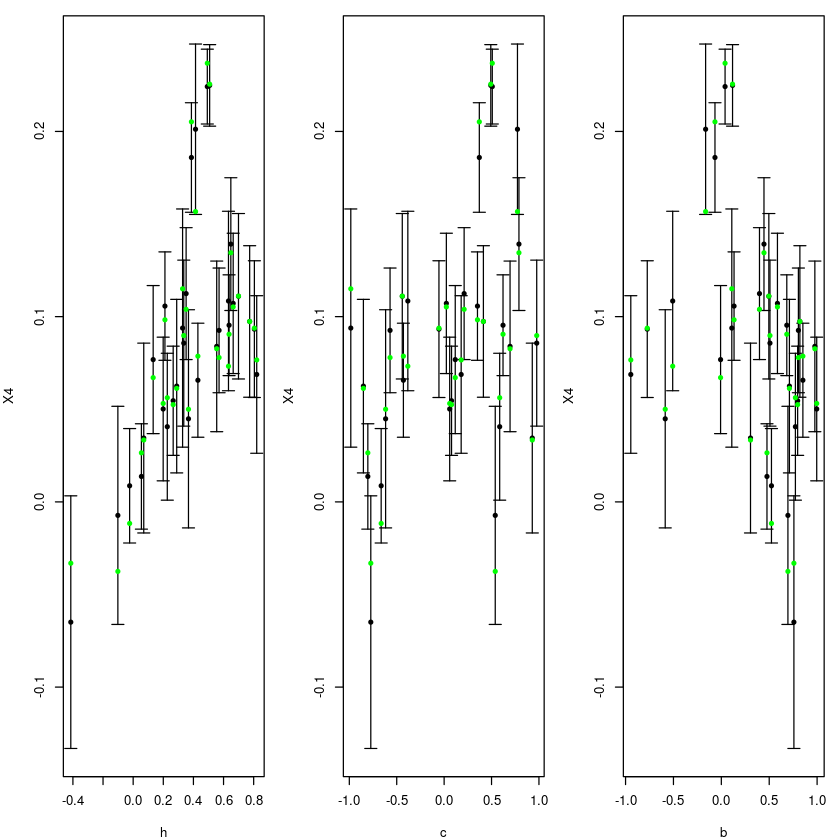

In [34]:
tLOOs <- LOO.plot(Emulators = em_wave2, which.emulator = 4, ParamNames = cands)

### Compute implausibility

In [35]:
sample_size <- 100000
nparam <- length(names(em_wave2$fitting.elements$Design))
Xp_wave2 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave2) <- names(em_wave2$fitting.elements$Design)
system.time(Timps_wave2 <- ImplausibilityMOGP(NewData=Xp_wave2, Emulator=em_wave2, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 26.704   8.259   5.553 

In [36]:
valmax = 0 #Set to 2 in order to have a "more steady" NROY space
cutoff <- 3 #the implausibility cut off

In [37]:
NROY2 <- which(rowSums(Timps_wave2 <= cutoff) >= em_wave2$mogp$n_emulators -valmax)
scoreNROY2 <- length(NROY2)/dim(Xp_wave2)[1]

### Layout of NROY space

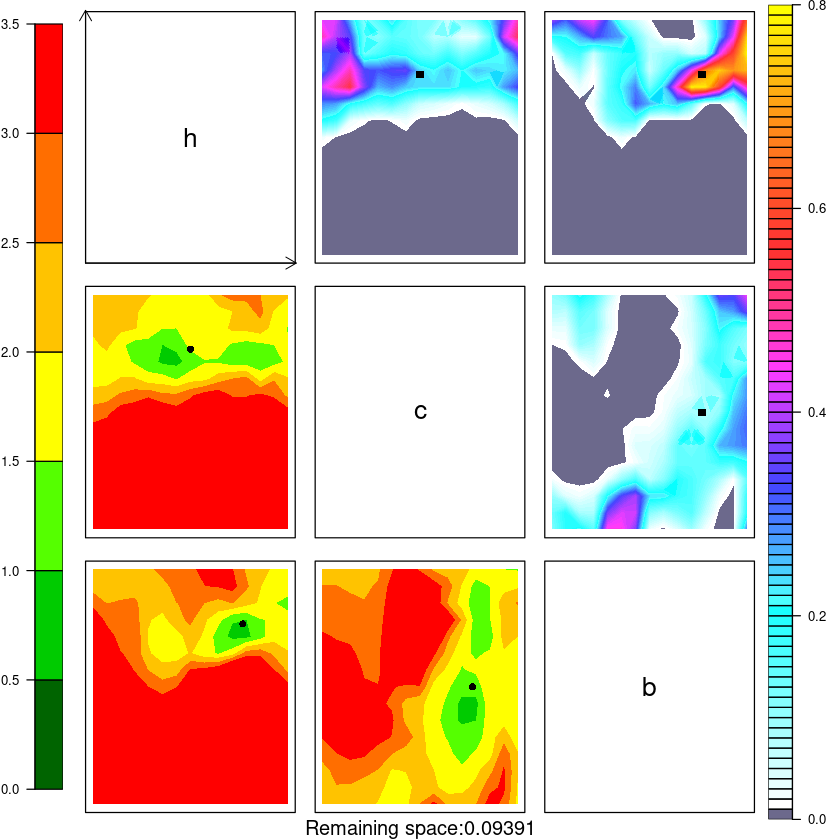

In [38]:
ImpData_wave2 = cbind(Xp_wave2, Timps_wave2)
ImpListM2 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave2, nEms=em_wave2$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM2,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY2,sep=""), side=1)

## Third Wave

In [42]:
n <- ceiling(n_samples*3/scoreNROY2)

In [43]:
inputs_wave3_scaled_temp <- np$array(lhs$generate(space$dimensions, as.integer(n), random_state=as.integer(42)))

In [44]:
emulators <- list(em_wave1, em_wave2)
NROY_temp_wave3 <- parameters_space(emulators, inputs_wave3_scaled_temp, n_samples=30)

In [45]:
length(NROY_temp_wave3)

[1] 30

In [46]:
input_wave3_scaled <- inputs_wave3_scaled_temp[sample(NROY_temp_wave3, n_samples),]
input_wave3 <- rangeUnscale(input_wave3_scaled, my_bounds, range = c(-1, 1))

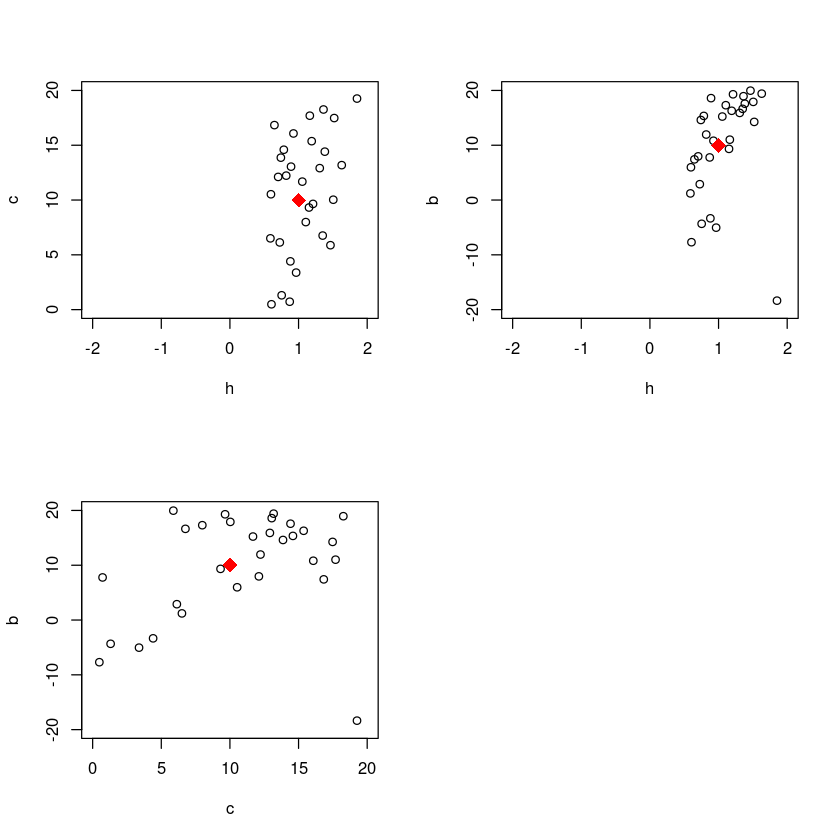

In [47]:
par(mfrow=c(2,2))
plot(input_wave3[,1], input_wave3[,2], xlab="h", ylab="c", xlim=c(-2,2), ylim=c(0,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,1], input_wave3[,3], xlab="h", ylab="b", xlim=c(-2,2), ylim=c(-20,20))
points(1, 10, col='red', pch=18, cex=2)
plot(input_wave3[,2], input_wave3[,3], xlab="c", ylab="b", xlim=c(0,20), ylim=c(-20,20))
points(10, 10, col='red', pch=18, cex=2)

In [48]:
metrics_wave3 = future_sapply(1:nrow(input_wave3), function(r) extract_metrics_AMIP(input_wave3[r,], n_iter, 0.001, X_hist), future.seed=NULL) 

### Create the data matrix

In [49]:
input_wave3_scaled <- data.frame(input_wave3_scaled)
names(input_wave3_scaled) <- c('h', 'c', 'b')


metrics_k_wave3 <- data.frame(t(metrics_wave3)[, metrics_index_k])
N = nrow(metrics_k_wave3) 
noise <- rnorm(N, 0, 0) # Tester à 0.5
tData_wave3 <- data.frame(cbind(input_wave3_scaled, noise, metrics_k_wave3))
names(tData_wave3)[names(tData_wave3) == "noise"] <- "Noise"
         
head(tData_wave3)

,h,c,b,Noise,X1,X2,X3,X4,X5,X6,⋯,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8144531,0.318359375,0.9707031,0,0.07282870,0.06739123,0.09176550,0.07760758,0.08984872,0.08541738,⋯,0.09247131,0.01956093,0.0007494693,0.01157650,0.09792773,0.02303553,-1.489914e-04,0.10132532,0.01708789,0.08961820
2,0.3769531,-0.869140625,-0.2167969,0,0.04431465,0.18380885,0.04879904,0.17611371,0.04459049,0.17588938,⋯,0.01440266,0.01481161,0.0106724256,0.01213089,0.04840577,0.01110163,5.276277e-02,0.01028671,0.01169609,0.06613250
3,0.3710938,0.386718750,0.7304688,0,0.06310853,0.06988651,0.06832319,0.08016582,0.05726914,0.06527524,⋯,0.03438702,0.01366835,0.0034070296,0.01076875,0.03037880,0.01026783,3.202711e-03,0.03409954,0.01069155,0.03372546
4,0.5527344,-0.201171875,0.8652344,0,0.05051411,0.06939249,0.09062368,0.07864147,0.06139806,0.10231615,⋯,0.05115512,0.01310797,0.0090501838,0.01544093,0.04535774,0.01400698,-3.549088e-05,0.07670774,0.02153010,0.06224784
5,0.5273438,0.167968750,0.7617188,0,0.04554668,0.07440393,0.06813772,0.07356301,0.08021256,0.06346520,⋯,0.06254811,0.01965492,0.0035111186,0.01515211,0.05682235,0.01612124,4.480967e-03,0.05026354,0.01570940,0.06366108
6,0.7529297,0.002929688,0.8955078,0,0.06540290,0.08734206,0.07826533,0.07355548,0.07514185,0.09945757,⋯,0.09462840,0.02058828,0.0012733146,0.01990008,0.08488604,0.01874591,5.618088e-04,0.10654588,0.01790199,0.07891010


### Training emulator

In [50]:
em_wave3 <- BuildNewEmulators(tData_wave3, HowManyEmulators = ncol(metrics_wave3), meanFun = "fitted", additionalVariables = cands) # 

[1] "Max reduction is 8.94136563474382e-05 using h"
[1] "Max reduction is 0.000156356072319772 using b"
[1] "Max reduction is 0.00803452259506629 using c"
[1] "Max reduction is 0.00769220214952264 using b"
[1] "Max reduction is 0.00520399420286478 using Three Way Interactions with b"
[1] "Max reduction is 0.00147607807249872 using c"
[1] "No permitted terms improve the fit"

Call:
lm(formula = X1 ~ h + b + I(b^2) + c + I(c^2) + I(b * h) + I(c * 
    h) + I(c * b) + I(b * b * h) + I(b * c * h) + I(b * c * b), 
    data = tData)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.020022 -0.004948 -0.000458  0.004560  0.017155 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.200902   0.027215   7.382 7.55e-07 ***
h            -0.253724   0.042624  -5.953 1.24e-05 ***
b            -0.237886   0.136698  -1.740 0.098887 .  
I(b^2)       -0.003551   0.129063  -0.028 0.978355    
c            -0.042017   0.044186  -0.951 0.354247    
I(c^2)  

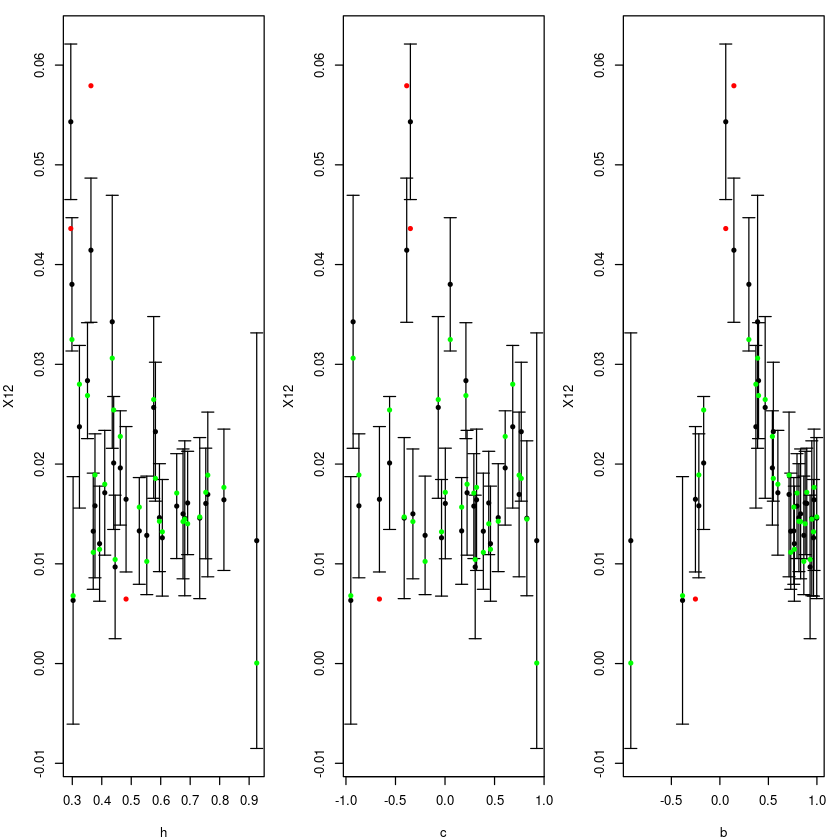

In [51]:
tLOOs <- LOO.plot(Emulators = em_wave3, which.emulator = 12, ParamNames = cands)

### Compute implausibility

In [52]:
sample_size <- 100000
nparam <- length(names(em_wave3$fitting.elements$Design))
Xp_wave3 <- as.data.frame(2*randomLHS(sample_size, nparam)-1)
names(Xp_wave3) <- names(em_wave3$fitting.elements$Design)
system.time(Timps_wave3 <- ImplausibilityMOGP(NewData=Xp_wave3, Emulator=em_wave3, Discrepancy=tDisc, Obs=tObs, ObsErr=tObsErr))

   user  system elapsed 
 26.544   5.726   5.197 

In [53]:
valmax = 0 #how many outputs can be above the implausibility cut off
cutoff <- 3 #the implausibility cut off

In [54]:
NROY3 <- which(rowSums(Timps_wave3 <= cutoff) >= em_wave3$mogp$n_emulators -valmax)
scoreNROY3 <- length(NROY3)/dim(Xp_wave3)[1]

### Layout of NROY space

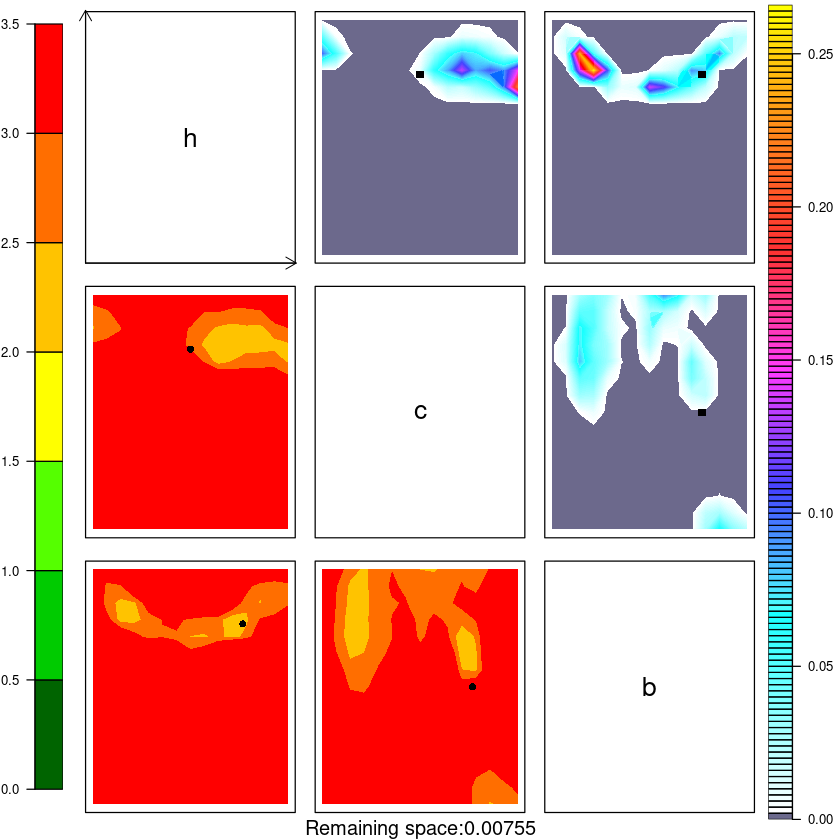

In [55]:
ImpData_wave3 = cbind(Xp_wave3, Timps_wave3)
ImpListM3 = CreateImpList(whichVars = 1:nparam, VarNames=VarNames, ImpData=ImpData_wave3, nEms=em_wave3$mogp$n_emulators, whichMax=valmax+1)
imp.layoutm11(ImpListM3,VarNames,VariableDensity=FALSE,newPDF=FALSE,the.title=paste("InputSpace_wave",WAVEN,".pdf",sep=""),newPNG=FALSE,newJPEG=FALSE,newEPS=FALSE,Points=matrix(param.defaults.norm,ncol=nparam))
mtext(paste("Remaining space:",scoreNROY3,sep=""), side=1)